# 第3章补充：新型激活函数与万能近似定理

> **学习目标：**
> - 理解Swish、GELU、Mish等新型激活函数的设计原理
> - 掌握万能近似定理（Universal Approximation Theorem）
> - 理解网络容量与表达能力的关系
> - 学会选择合适的激活函数
>
> **前置知识：** 03_mlp_forward.ipynb 的内容
>
> **学习时间：** 2-3小时

---

In [1]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)

# 设置绘图风格
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',  # macOS通用
    'PingFang SC',       # macOS系统字体
    'STHeiti',           # 华文黑体
    'Heiti TC',          # 黑体-繁
    'SimHei',            # 黑体
]
plt.rcParams['axes.unicode_minus'] = False

print("环境配置完成！")

环境配置完成！


---

## 1. 传统激活函数回顾

### 1.1 ReLU及其变体的问题

**ReLU的优点：**
- 计算简单高效
- 缓解梯度消失问题
- 稀疏激活特性

**ReLU的问题：**
- **Dead ReLU问题**：当输入为负时，梯度为0，神经元可能永久"死亡"
- **非零中心化**：输出总是非负的
- **不连续的导数**：在$x=0$处不可微

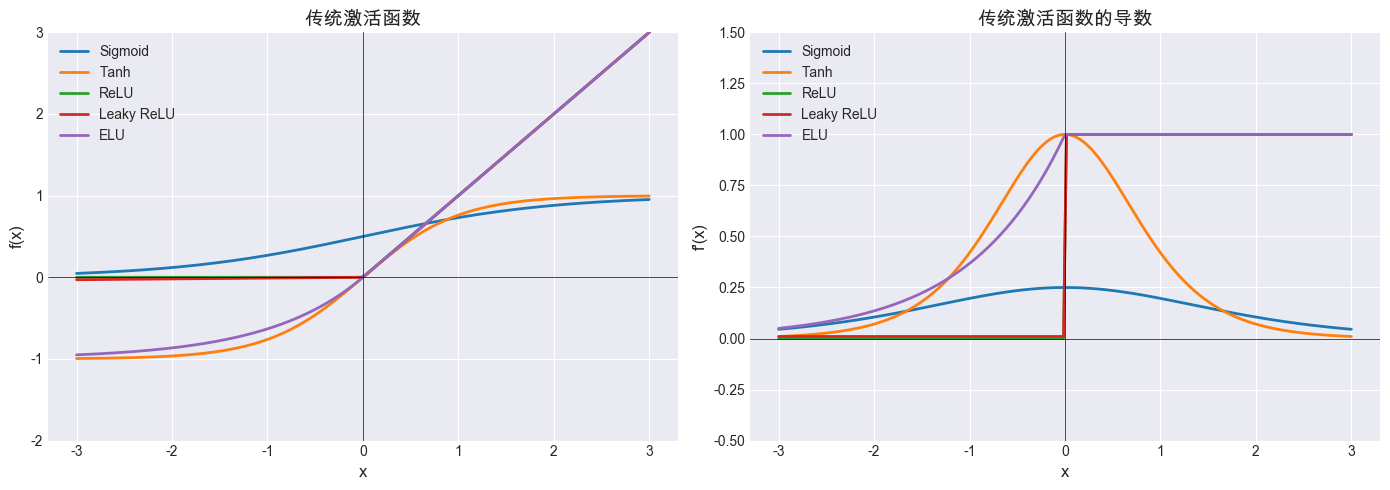

In [2]:
# 传统激活函数
def sigmoid(x):
    """Sigmoid激活函数: σ(x) = 1 / (1 + e^(-x))"""
    return 1 / (1 + np.exp(-np.clip(x, -500, 500)))

def tanh(x):
    """Tanh激活函数: tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))"""
    return np.tanh(x)

def relu(x):
    """ReLU激活函数: ReLU(x) = max(0, x)"""
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    """Leaky ReLU: f(x) = x if x > 0 else alpha * x"""
    return np.where(x > 0, x, alpha * x)

def elu(x, alpha=1.0):
    """ELU: f(x) = x if x > 0 else alpha * (e^x - 1)"""
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

# 可视化
def plot_classic_activations():
    x = np.linspace(-3, 3, 200)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：函数值
    ax1 = axes[0]
    ax1.plot(x, sigmoid(x), label='Sigmoid', linewidth=2)
    ax1.plot(x, tanh(x), label='Tanh', linewidth=2)
    ax1.plot(x, relu(x), label='ReLU', linewidth=2)
    ax1.plot(x, leaky_relu(x), label='Leaky ReLU', linewidth=2)
    ax1.plot(x, elu(x), label='ELU', linewidth=2)
    ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax1.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('f(x)', fontsize=12)
    ax1.set_title('传统激活函数', fontsize=14)
    ax1.legend()
    ax1.set_ylim(-2, 3)
    
    # 右图：导数
    ax2 = axes[1]
    # 数值计算导数
    eps = 1e-5
    ax2.plot(x, (sigmoid(x+eps) - sigmoid(x-eps)) / (2*eps), label='Sigmoid', linewidth=2)
    ax2.plot(x, (tanh(x+eps) - tanh(x-eps)) / (2*eps), label='Tanh', linewidth=2)
    ax2.plot(x, np.where(x > 0, 1, 0), label='ReLU', linewidth=2)
    ax2.plot(x, np.where(x > 0, 1, 0.01), label='Leaky ReLU', linewidth=2)
    ax2.plot(x, np.where(x > 0, 1, elu(x) + 1), label='ELU', linewidth=2)
    ax2.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax2.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel("f'(x)", fontsize=12)
    ax2.set_title('传统激活函数的导数', fontsize=14)
    ax2.legend()
    ax2.set_ylim(-0.5, 1.5)
    
    plt.tight_layout()
    plt.show()

plot_classic_activations()

---

## 2. 新型激活函数

### 2.1 Swish激活函数

Swish由Google Brain在2017年通过**自动搜索**发现：

$$\text{Swish}(x) = x \cdot \sigma(\beta x) = \frac{x}{1 + e^{-\beta x}}$$

其中$\beta$是可学习或固定的参数，$\sigma$是Sigmoid函数。当$\beta=1$时：

$$\text{Swish}(x) = \frac{x}{1 + e^{-x}}$$

**特点：**
- 平滑：处处可微
- 非单调：在负区间有一个"凹陷"
- 无上界：像ReLU一样可以输出很大的值
- 有下界：最小值约为-0.278

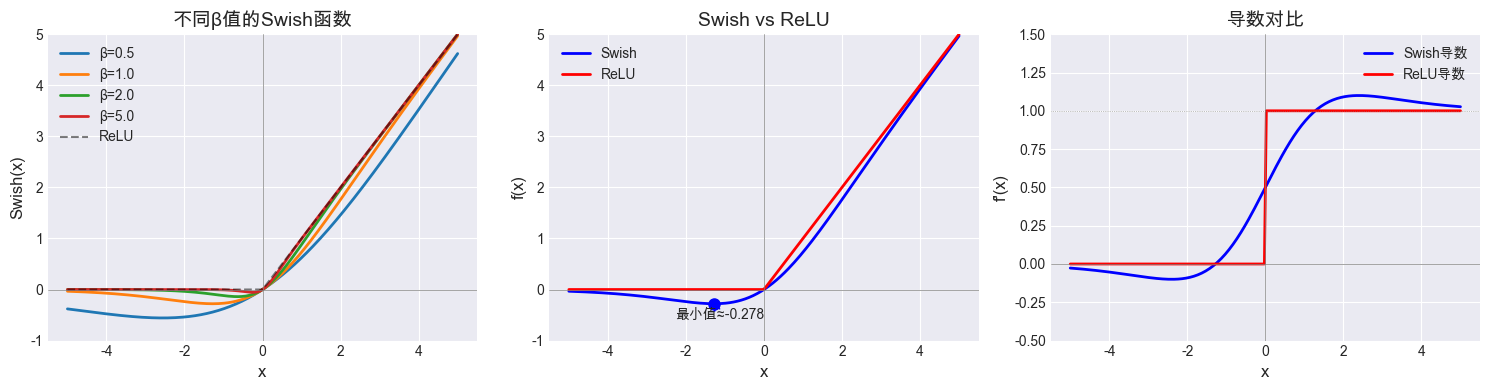

Swish的关键特点：
1. 平滑可微（不像ReLU在0处有拐点）
2. 非单调（负区间有一个'凹陷'，允许负值通过）
3. 自门控机制：sigmoid(x)作为门控制信号的通过
4. 当β→∞时，Swish趋近于ReLU


In [3]:
def swish(x, beta=1.0):
    """
    Swish激活函数 - 从零实现
    
    公式: Swish(x) = x * sigmoid(β * x)
    
    参数:
        x: numpy数组, 输入
        beta: float, 缩放参数，默认为1.0
              beta=0时退化为线性函数 x/2
              beta→∞时接近ReLU
    
    返回:
        Swish激活值
    
    特点:
        - 平滑非单调
        - 自门控机制: sigmoid(βx)作为"门"控制x的通过程度
        - 在负区间有小的负输出（与ReLU不同）
    """
    # Swish = x * sigmoid(beta * x)
    # sigmoid(z) = 1 / (1 + exp(-z))
    return x * sigmoid(beta * x)


def swish_derivative(x, beta=1.0):
    """
    Swish激活函数的导数
    
    推导:
        令 σ = sigmoid(βx)
        Swish(x) = x * σ
        d/dx[Swish(x)] = σ + x * σ' 
                       = σ + x * β * σ * (1 - σ)
                       = σ + β * x * σ * (1 - σ)
                       = σ * (1 + β * x * (1 - σ))
    
    也可以写成:
        d/dx[Swish(x)] = β * Swish(x) + σ * (1 - β * Swish(x))
    """
    sig = sigmoid(beta * x)
    swish_val = x * sig
    return beta * swish_val + sig * (1 - beta * swish_val)


# 可视化Swish
def visualize_swish():
    x = np.linspace(-5, 5, 200)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 左图：不同beta值的Swish
    ax1 = axes[0]
    for beta in [0.5, 1.0, 2.0, 5.0]:
        ax1.plot(x, swish(x, beta), label=f'β={beta}', linewidth=2)
    ax1.plot(x, relu(x), 'k--', label='ReLU', linewidth=1.5, alpha=0.5)
    ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax1.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('Swish(x)', fontsize=12)
    ax1.set_title('不同β值的Swish函数', fontsize=14)
    ax1.legend()
    ax1.set_ylim(-1, 5)
    
    # 中图：Swish与ReLU对比
    ax2 = axes[1]
    ax2.plot(x, swish(x, 1.0), 'b-', label='Swish', linewidth=2)
    ax2.plot(x, relu(x), 'r-', label='ReLU', linewidth=2)
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax2.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    
    # 标记Swish的最小值
    x_min = -1.278  # 近似最小值位置
    y_min = swish(x_min)
    ax2.plot(x_min, y_min, 'bo', markersize=8)
    ax2.annotate(f'最小值≈{y_min:.3f}', xy=(x_min, y_min), 
                 xytext=(x_min-1, y_min-0.3), fontsize=10,
                 arrowprops=dict(arrowstyle='->', color='blue'))
    
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('f(x)', fontsize=12)
    ax2.set_title('Swish vs ReLU', fontsize=14)
    ax2.legend()
    ax2.set_ylim(-1, 5)
    
    # 右图：导数对比
    ax3 = axes[2]
    ax3.plot(x, swish_derivative(x, 1.0), 'b-', label='Swish导数', linewidth=2)
    ax3.plot(x, np.where(x > 0, 1, 0), 'r-', label='ReLU导数', linewidth=2)
    ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax3.axhline(y=1, color='gray', linestyle=':', linewidth=0.5)
    ax3.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax3.set_xlabel('x', fontsize=12)
    ax3.set_ylabel("f'(x)", fontsize=12)
    ax3.set_title('导数对比', fontsize=14)
    ax3.legend()
    ax3.set_ylim(-0.5, 1.5)
    
    plt.tight_layout()
    plt.show()
    
    print("Swish的关键特点：")
    print("1. 平滑可微（不像ReLU在0处有拐点）")
    print("2. 非单调（负区间有一个'凹陷'，允许负值通过）")
    print("3. 自门控机制：sigmoid(x)作为门控制信号的通过")
    print("4. 当β→∞时，Swish趋近于ReLU")

visualize_swish()

### 2.2 GELU激活函数

GELU（Gaussian Error Linear Unit）由Hendrycks & Gimpel在2016年提出，在BERT、GPT等Transformer模型中广泛使用。

$$\text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2}\left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]$$

其中$\Phi(x)$是标准正态分布的累积分布函数（CDF），$\text{erf}$是误差函数。

**近似形式**（计算更快）：
$$\text{GELU}(x) \approx 0.5x\left[1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right)\right]$$

**设计思想：**
- 输入$x$乘以$\Phi(x)$（$x$小于0的概率）
- 相当于**随机门控**：输入越大，越可能被保留

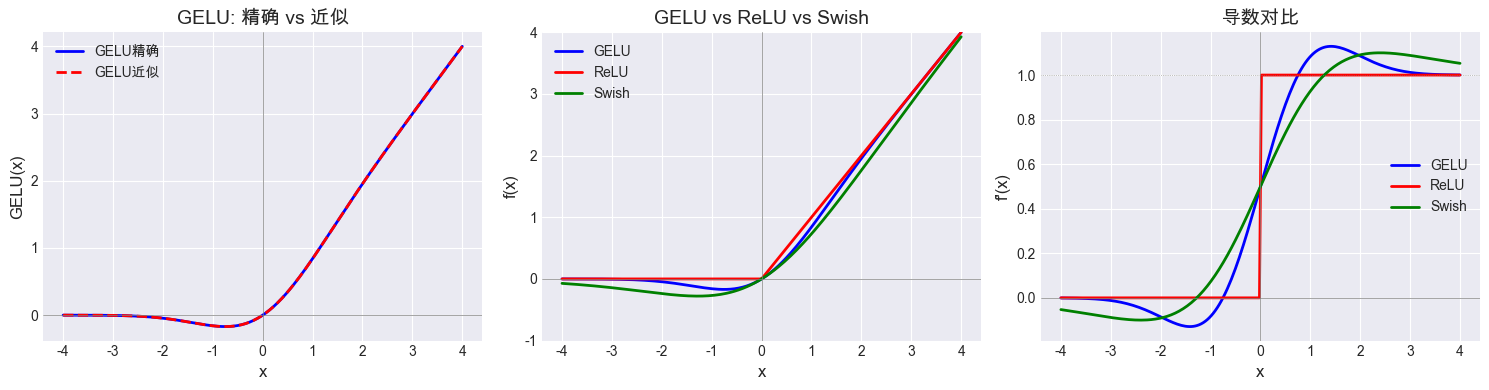


近似误差: 最大绝对误差 = 0.000473

GELU的应用：
- BERT、GPT等Transformer模型的默认激活函数
- 在NLP任务中表现优于ReLU


In [4]:
def gelu_exact(x):
    """
    GELU激活函数 - 精确实现
    
    公式: GELU(x) = x * Φ(x)
          其中 Φ(x) = 0.5 * (1 + erf(x / √2)) 是标准正态CDF
    
    参数:
        x: numpy数组, 输入
    
    返回:
        GELU激活值
    
    直觉理解:
        - Φ(x) = P(X ≤ x)，其中X~N(0,1)
        - 当x很大时，Φ(x)→1，GELU(x)→x
        - 当x很小时，Φ(x)→0，GELU(x)→0
        - 相当于用"输入值是否大于标准正态采样"来门控
    """
    # 标准正态分布的CDF
    # Φ(x) = 0.5 * (1 + erf(x / √2))
    phi = 0.5 * (1 + erf(x / np.sqrt(2)))
    return x * phi


def gelu_approx(x):
    """
    GELU激活函数 - 近似实现（计算更快）
    
    近似公式:
        GELU(x) ≈ 0.5 * x * (1 + tanh(√(2/π) * (x + 0.044715 * x³)))
    
    这个近似在实践中被广泛使用，因为tanh比erf计算更快
    """
    # 常数
    sqrt_2_over_pi = np.sqrt(2 / np.pi)  # ≈ 0.7979
    coeff = 0.044715
    
    # 近似公式
    return 0.5 * x * (1 + np.tanh(sqrt_2_over_pi * (x + coeff * x**3)))


def gelu_derivative(x):
    """
    GELU激活函数的导数
    
    推导:
        GELU(x) = x * Φ(x)
        d/dx[GELU(x)] = Φ(x) + x * Φ'(x)
                      = Φ(x) + x * φ(x)
        其中 φ(x) = (1/√(2π)) * exp(-x²/2) 是标准正态PDF
    """
    phi = 0.5 * (1 + erf(x / np.sqrt(2)))  # CDF
    pdf = np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)  # PDF
    return phi + x * pdf


# 可视化GELU
def visualize_gelu():
    x = np.linspace(-4, 4, 200)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 左图：GELU精确vs近似
    ax1 = axes[0]
    ax1.plot(x, gelu_exact(x), 'b-', label='GELU精确', linewidth=2)
    ax1.plot(x, gelu_approx(x), 'r--', label='GELU近似', linewidth=2)
    ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax1.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('GELU(x)', fontsize=12)
    ax1.set_title('GELU: 精确 vs 近似', fontsize=14)
    ax1.legend()
    
    # 中图：GELU与其他激活函数对比
    ax2 = axes[1]
    ax2.plot(x, gelu_exact(x), 'b-', label='GELU', linewidth=2)
    ax2.plot(x, relu(x), 'r-', label='ReLU', linewidth=2)
    ax2.plot(x, swish(x), 'g-', label='Swish', linewidth=2)
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax2.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel('f(x)', fontsize=12)
    ax2.set_title('GELU vs ReLU vs Swish', fontsize=14)
    ax2.legend()
    ax2.set_ylim(-1, 4)
    
    # 右图：导数
    ax3 = axes[2]
    ax3.plot(x, gelu_derivative(x), 'b-', label='GELU', linewidth=2)
    ax3.plot(x, np.where(x > 0, 1, 0), 'r-', label='ReLU', linewidth=2)
    ax3.plot(x, swish_derivative(x), 'g-', label='Swish', linewidth=2)
    ax3.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax3.axhline(y=1, color='gray', linestyle=':', linewidth=0.5)
    ax3.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax3.set_xlabel('x', fontsize=12)
    ax3.set_ylabel("f'(x)", fontsize=12)
    ax3.set_title('导数对比', fontsize=14)
    ax3.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 验证近似精度
    max_error = np.max(np.abs(gelu_exact(x) - gelu_approx(x)))
    print(f"\n近似误差: 最大绝对误差 = {max_error:.6f}")
    print("\nGELU的应用：")
    print("- BERT、GPT等Transformer模型的默认激活函数")
    print("- 在NLP任务中表现优于ReLU")

visualize_gelu()

### 2.3 Mish激活函数

Mish由Misra在2019年提出：

$$\text{Mish}(x) = x \cdot \tanh(\text{softplus}(x)) = x \cdot \tanh(\ln(1 + e^x))$$

**特点：**
- 平滑、非单调
- 无上界、有下界（最小值约-0.31）
- 比Swish在某些视觉任务上表现更好

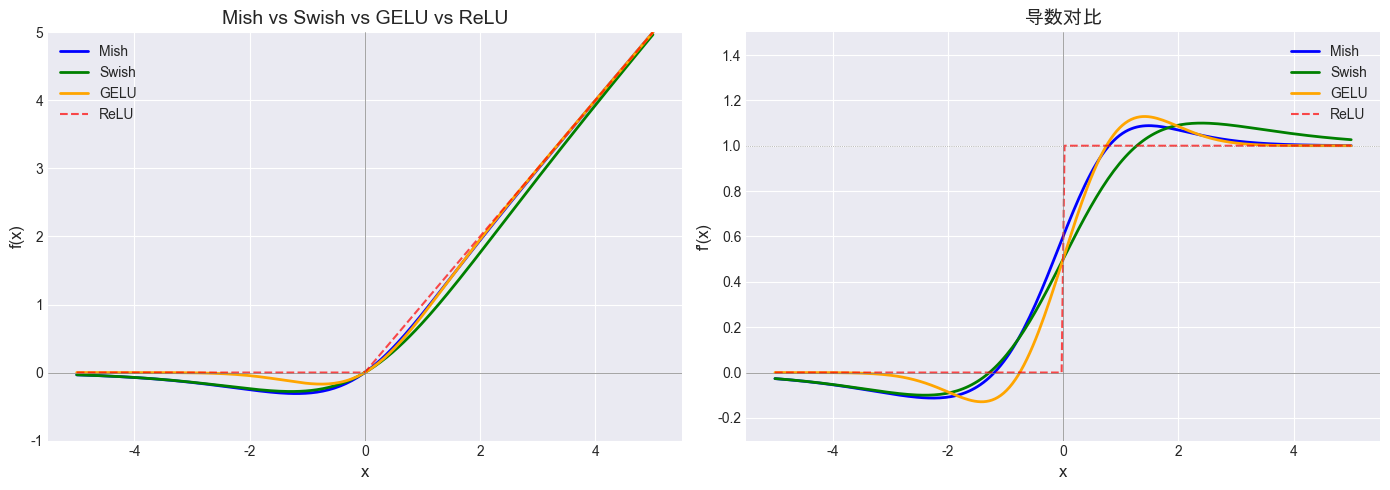

In [5]:
def softplus(x):
    """
    Softplus激活函数: softplus(x) = ln(1 + e^x)
    
    这是ReLU的平滑版本
    
    数值稳定性处理:
        当x很大时，直接计算e^x会溢出
        使用 softplus(x) = x + ln(1 + e^(-|x|)) 的等价形式
    """
    return np.where(x > 20, x, np.log1p(np.exp(np.clip(x, -500, 20))))


def mish(x):
    """
    Mish激活函数 - 从零实现
    
    公式: Mish(x) = x * tanh(softplus(x))
                 = x * tanh(ln(1 + e^x))
    
    参数:
        x: numpy数组, 输入
    
    返回:
        Mish激活值
    
    特点:
        - 平滑：处处可微
        - 非单调：负区间有小的负输出
        - 自正则化：在负区间允许梯度流动
    """
    return x * np.tanh(softplus(x))


def mish_derivative(x):
    """
    Mish激活函数的导数
    
    令 ω = 4(x + 1) + 4e^(2x) + e^(3x) + e^x(4x + 6)
       δ = 2e^x + e^(2x) + 2
    
    则 Mish'(x) = e^x * ω / δ²
    
    这里使用数值微分简化计算
    """
    eps = 1e-5
    return (mish(x + eps) - mish(x - eps)) / (2 * eps)


# 可视化Mish
def visualize_mish():
    x = np.linspace(-5, 5, 200)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 左图：Mish与其他激活函数对比
    ax1 = axes[0]
    ax1.plot(x, mish(x), 'b-', label='Mish', linewidth=2)
    ax1.plot(x, swish(x), 'g-', label='Swish', linewidth=2)
    ax1.plot(x, gelu_exact(x), 'orange', label='GELU', linewidth=2)
    ax1.plot(x, relu(x), 'r--', label='ReLU', linewidth=1.5, alpha=0.7)
    ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax1.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('f(x)', fontsize=12)
    ax1.set_title('Mish vs Swish vs GELU vs ReLU', fontsize=14)
    ax1.legend()
    ax1.set_ylim(-1, 5)
    
    # 右图：导数对比
    ax2 = axes[1]
    ax2.plot(x, mish_derivative(x), 'b-', label='Mish', linewidth=2)
    ax2.plot(x, swish_derivative(x), 'g-', label='Swish', linewidth=2)
    ax2.plot(x, gelu_derivative(x), 'orange', label='GELU', linewidth=2)
    ax2.plot(x, np.where(x > 0, 1, 0), 'r--', label='ReLU', linewidth=1.5, alpha=0.7)
    ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax2.axhline(y=1, color='gray', linestyle=':', linewidth=0.5)
    ax2.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
    ax2.set_xlabel('x', fontsize=12)
    ax2.set_ylabel("f'(x)", fontsize=12)
    ax2.set_title('导数对比', fontsize=14)
    ax2.legend()
    ax2.set_ylim(-0.3, 1.5)
    
    plt.tight_layout()
    plt.show()

visualize_mish()

### 2.4 激活函数对比总结

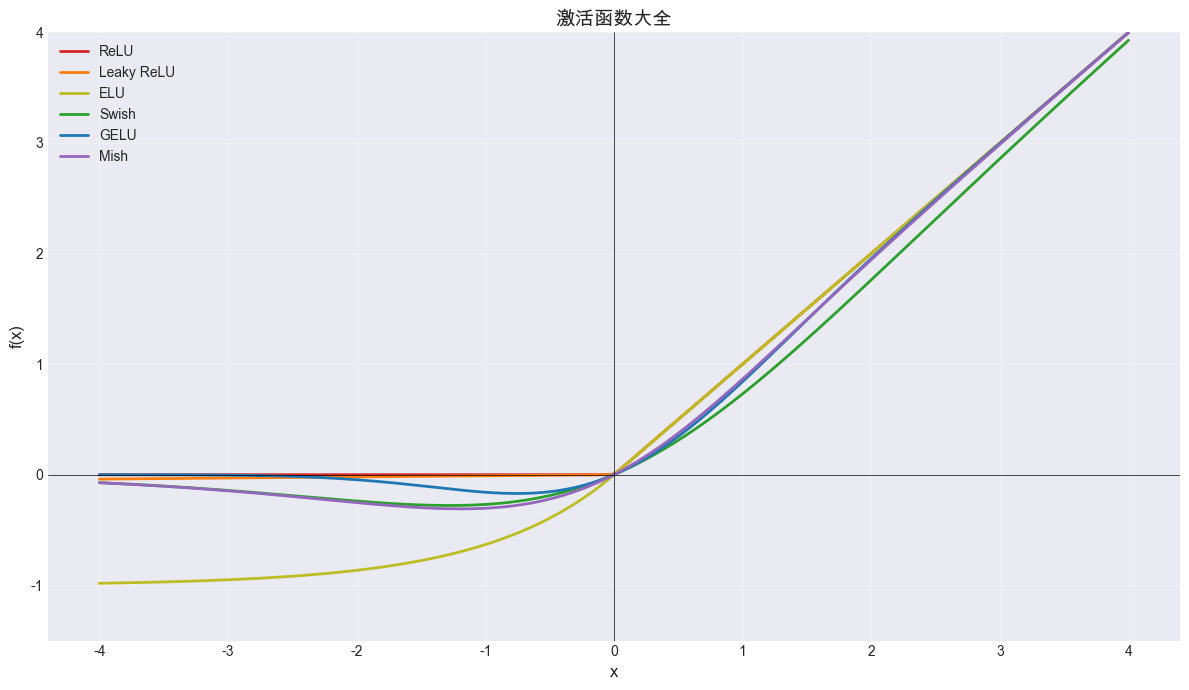


激活函数特性对比：
          函数 |     平滑 |     单调 |      零中心 |      负区间梯度 | 典型应用
--------------------------------------------------------------------------------
        ReLU |      否 |      是 |        否 |          0 | CNN基础
  Leaky ReLU |      否 |      是 |       近似 |       0.01 | CNN
         ELU |      是 |      是 |       近似 |         正值 | CNN
       Swish |      是 |      否 |       近似 |         可变 | EfficientNet
        GELU |      是 |      否 |       近似 |         可变 | Transformer
        Mish |      是 |      否 |       近似 |         可变 | YOLOv4


In [6]:
def compare_all_activations():
    """
    全面对比所有激活函数
    """
    x = np.linspace(-4, 4, 200)
    
    activations = [
        ('ReLU', relu(x), 'tab:red'),
        ('Leaky ReLU', leaky_relu(x), 'tab:orange'),
        ('ELU', elu(x), 'tab:olive'),
        ('Swish', swish(x), 'tab:green'),
        ('GELU', gelu_exact(x), 'tab:blue'),
        ('Mish', mish(x), 'tab:purple'),
    ]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    for name, y, color in activations:
        ax.plot(x, y, label=name, linewidth=2, color=color)
    
    ax.axhline(y=0, color='k', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='-', linewidth=0.5)
    ax.set_xlabel('x', fontsize=12)
    ax.set_ylabel('f(x)', fontsize=12)
    ax.set_title('激活函数大全', fontsize=14)
    ax.legend(loc='upper left')
    ax.set_ylim(-1.5, 4)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 打印对比表格
    print("\n激活函数特性对比：")
    print("=" * 80)
    print(f"{'函数':>12} | {'平滑':>6} | {'单调':>6} | {'零中心':>8} | {'负区间梯度':>10} | {'典型应用'}")
    print("-" * 80)
    print(f"{'ReLU':>12} | {'否':>6} | {'是':>6} | {'否':>8} | {'0':>10} | CNN基础")
    print(f"{'Leaky ReLU':>12} | {'否':>6} | {'是':>6} | {'近似':>8} | {'0.01':>10} | CNN")
    print(f"{'ELU':>12} | {'是':>6} | {'是':>6} | {'近似':>8} | {'正值':>10} | CNN")
    print(f"{'Swish':>12} | {'是':>6} | {'否':>6} | {'近似':>8} | {'可变':>10} | EfficientNet")
    print(f"{'GELU':>12} | {'是':>6} | {'否':>6} | {'近似':>8} | {'可变':>10} | Transformer")
    print(f"{'Mish':>12} | {'是':>6} | {'否':>6} | {'近似':>8} | {'可变':>10} | YOLOv4")
    print("=" * 80)

compare_all_activations()

---

## 3. 万能近似定理（Universal Approximation Theorem）

### 3.1 定理陈述

**万能近似定理（1989年，Cybenko; 1991年，Hornik）：**

设$\sigma$是一个非常值的、有界的、单调递增的连续函数。对于任意紧集$I_m \subset \mathbb{R}^m$上的连续函数$f$和任意$\epsilon > 0$，存在整数$N$、实数$v_i, b_i$和实向量$w_i \in \mathbb{R}^m$，使得：

$$F(x) = \sum_{i=1}^{N} v_i \sigma(w_i^T x + b_i)$$

满足：
$$|F(x) - f(x)| < \epsilon, \quad \forall x \in I_m$$

**通俗解释：**
- 一个具有**单隐藏层**和**足够多神经元**的神经网络
- 可以以**任意精度**近似任意连续函数
- 激活函数需要满足一定条件（非线性）

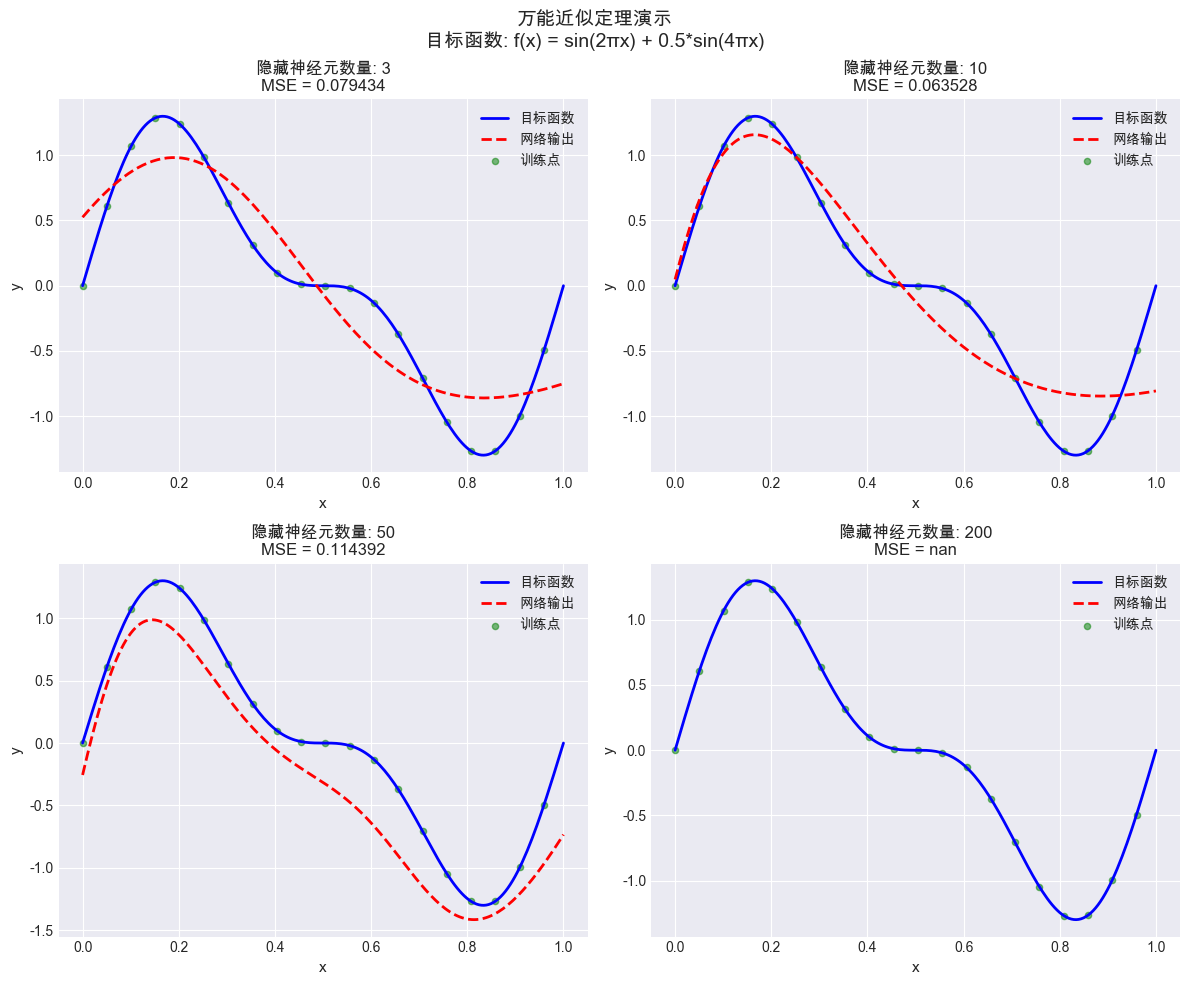


关键观察：
1. 随着神经元数量增加，近似误差减小
2. 即使是单隐藏层网络，也能近似复杂的非线性函数
3. 这验证了万能近似定理：足够宽的网络可以近似任意连续函数

注意：
- 定理只说'存在'这样的网络，没说如何找到
- 所需神经元数量可能随问题复杂度指数增长
- 实践中，深层网络通常比宽而浅的网络更高效


In [7]:
def demonstrate_universal_approximation():
    """
    演示万能近似定理：用单隐藏层网络近似复杂函数
    
    目标函数: f(x) = sin(2πx) + 0.5*sin(4πx)
    
    展示不同神经元数量的近似效果
    """
    # 目标函数
    def target_function(x):
        return np.sin(2 * np.pi * x) + 0.5 * np.sin(4 * np.pi * x)
    
    # 单隐藏层网络（随机初始化，不训练）
    def random_network(x, n_hidden, seed=None):
        if seed is not None:
            np.random.seed(seed)
        
        # 随机权重
        W1 = np.random.randn(1, n_hidden) * 2
        b1 = np.random.randn(n_hidden) * 2
        W2 = np.random.randn(n_hidden, 1)
        b2 = np.random.randn(1)
        
        # 前向传播
        x = x.reshape(-1, 1)
        h = np.tanh(x @ W1 + b1)
        y = h @ W2 + b2
        
        return y.flatten()
    
    # 简单的梯度下降训练（用于演示）
    def train_network(x_train, y_train, n_hidden, n_iter=5000, lr=0.01):
        """
        训练单隐藏层网络
        """
        n_samples = len(x_train)
        x_train = x_train.reshape(-1, 1)
        y_train = y_train.reshape(-1, 1)
        
        # Xavier初始化
        W1 = np.random.randn(1, n_hidden) * np.sqrt(2.0 / 1)
        b1 = np.zeros(n_hidden)
        W2 = np.random.randn(n_hidden, 1) * np.sqrt(2.0 / n_hidden)
        b2 = np.zeros(1)
        
        for i in range(n_iter):
            # 前向传播
            z1 = x_train @ W1 + b1
            h = np.tanh(z1)
            y_pred = h @ W2 + b2
            
            # 损失
            loss = np.mean((y_pred - y_train) ** 2)
            
            # 反向传播
            dy = 2 * (y_pred - y_train) / n_samples
            dW2 = h.T @ dy
            db2 = np.sum(dy, axis=0)
            dh = dy @ W2.T
            dz1 = dh * (1 - h**2)  # tanh导数
            dW1 = x_train.T @ dz1
            db1 = np.sum(dz1, axis=0)
            
            # 更新
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2
        
        def predict(x):
            x = x.reshape(-1, 1)
            h = np.tanh(x @ W1 + b1)
            return (h @ W2 + b2).flatten()
        
        return predict, loss
    
    # 训练数据
    x_train = np.linspace(0, 1, 100)
    y_train = target_function(x_train)
    
    # 测试数据
    x_test = np.linspace(0, 1, 200)
    y_test = target_function(x_test)
    
    # 不同神经元数量
    hidden_sizes = [3, 10, 50, 200]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    for ax, n_hidden in zip(axes.flat, hidden_sizes):
        # 训练网络
        predict, loss = train_network(x_train, y_train, n_hidden, n_iter=10000, lr=0.1)
        y_pred = predict(x_test)
        
        # 计算误差
        mse = np.mean((y_pred - y_test) ** 2)
        
        # 绘图
        ax.plot(x_test, y_test, 'b-', label='目标函数', linewidth=2)
        ax.plot(x_test, y_pred, 'r--', label='网络输出', linewidth=2)
        ax.scatter(x_train[::5], y_train[::5], c='green', s=20, alpha=0.5, label='训练点')
        ax.set_xlabel('x', fontsize=11)
        ax.set_ylabel('y', fontsize=11)
        ax.set_title(f'隐藏神经元数量: {n_hidden}\nMSE = {mse:.6f}', fontsize=12)
        ax.legend()
    
    plt.suptitle('万能近似定理演示\n目标函数: f(x) = sin(2πx) + 0.5*sin(4πx)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n关键观察：")
    print("1. 随着神经元数量增加，近似误差减小")
    print("2. 即使是单隐藏层网络，也能近似复杂的非线性函数")
    print("3. 这验证了万能近似定理：足够宽的网络可以近似任意连续函数")
    print("\n注意：")
    print("- 定理只说'存在'这样的网络，没说如何找到")
    print("- 所需神经元数量可能随问题复杂度指数增长")
    print("- 实践中，深层网络通常比宽而浅的网络更高效")

demonstrate_universal_approximation()

### 3.2 定理的意义与局限

**意义：**
1. 理论保证：神经网络具有强大的表达能力
2. 设计指导：只要网络足够大，就能学习任何映射

**局限：**
1. **存在性定理**：只证明存在，不说明如何找到
2. **所需规模未知**：可能需要指数级多的神经元
3. **训练难度**：大网络难以优化
4. **泛化问题**：能拟合不代表能泛化

**深度vs宽度：**
- 万能近似定理针对宽度（神经元数量）
- 实践表明，深度（层数）通常更重要
- 深层网络可以用更少的参数表达复杂函数

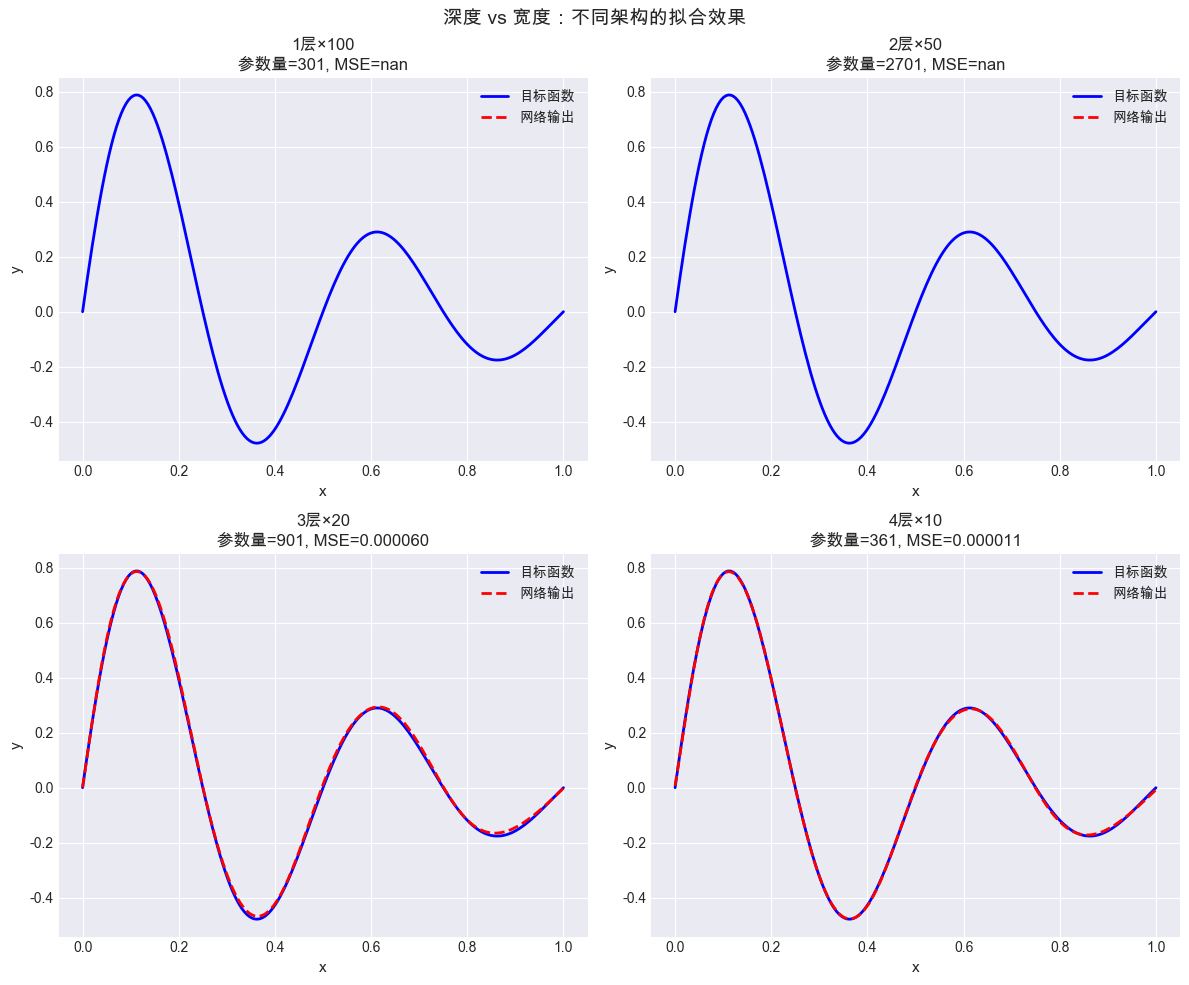


结论：
- 相同参数量下，不同架构的表达能力可能差异很大
- 深层网络通常能更高效地表达复杂函数
- 但过深的网络可能面临优化困难（梯度消失/爆炸）


In [9]:
def compare_depth_vs_width():
    """
    比较深度和宽度对网络表达能力的影响
    """
    # 目标函数：更复杂的函数
    def target_function(x):
        return np.sin(4 * np.pi * x) * np.exp(-2 * x)
    
    x_train = np.linspace(0, 1, 100)
    y_train = target_function(x_train)
    x_test = np.linspace(0, 1, 200)
    y_test = target_function(x_test)
    
    def train_deep_network(x_train, y_train, hidden_sizes, n_iter=10000, lr=0.01):
        """
        训练多层网络
        
        参数:
            hidden_sizes: list, 每层的神经元数量
        """
        n_samples = len(x_train)
        x = x_train.reshape(-1, 1)
        y = y_train.reshape(-1, 1)
        
        # 初始化所有层的权重
        layer_sizes = [1] + hidden_sizes + [1]
        weights = []
        biases = []
        
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2.0 / layer_sizes[i])
            b = np.zeros(layer_sizes[i+1])
            weights.append(w)
            biases.append(b)
        
        # 训练
        for _ in range(n_iter):
            # 前向传播
            activations = [x]
            for i in range(len(weights) - 1):
                z = activations[-1] @ weights[i] + biases[i]
                a = np.tanh(z)
                activations.append(a)
            # 最后一层无激活
            y_pred = activations[-1] @ weights[-1] + biases[-1]
            
            # 反向传播
            dy = 2 * (y_pred - y) / n_samples
            
            grads_w = []
            grads_b = []
            
            # 最后一层
            grads_w.insert(0, activations[-1].T @ dy)
            grads_b.insert(0, np.sum(dy, axis=0))
            delta = dy @ weights[-1].T
            
            # 隐藏层
            for i in range(len(weights) - 2, -1, -1):
                delta = delta * (1 - activations[i+1]**2)  # tanh导数
                grads_w.insert(0, activations[i].T @ delta)
                grads_b.insert(0, np.sum(delta, axis=0))
                if i > 0:
                    delta = delta @ weights[i].T
            
            # 更新
            for i in range(len(weights)):
                weights[i] -= lr * grads_w[i]
                biases[i] -= lr * grads_b[i]
        
        def predict(x):
            x = x.reshape(-1, 1)
            a = x
            for i in range(len(weights) - 1):
                z = a @ weights[i] + biases[i]
                a = np.tanh(z)
            return (a @ weights[-1] + biases[-1]).flatten()
        
        mse = np.mean((y_pred - y) ** 2)
        n_params = sum(w.size + b.size for w, b in zip(weights, biases))
        
        return predict, mse, n_params
    
    # 比较不同架构（相似参数量）
    architectures = [
        ([100], '1层×100'),          # 宽而浅
        ([50, 50], '2层×50'),         # 中等
        ([20, 20, 20], '3层×20'),     # 较深
        ([10, 10, 10, 10], '4层×10'), # 深而窄
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    for ax, (hidden_sizes, name) in zip(axes.flat, architectures):
        predict, mse, n_params = train_deep_network(
            x_train, y_train, hidden_sizes, n_iter=15000, lr=0.1
        )
        y_pred = predict(x_test)
        
        ax.plot(x_test, y_test, 'b-', label='目标函数', linewidth=2)
        ax.plot(x_test, y_pred, 'r--', label='网络输出', linewidth=2)
        ax.set_xlabel('x', fontsize=11)
        ax.set_ylabel('y', fontsize=11)
        ax.set_title(f'{name}\n参数量={n_params}, MSE={mse:.6f}', fontsize=12)
        ax.legend()
    
    plt.suptitle('深度 vs 宽度：不同架构的拟合效果', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n结论：")
    print("- 相同参数量下，不同架构的表达能力可能差异很大")
    print("- 深层网络通常能更高效地表达复杂函数")
    print("- 但过深的网络可能面临优化困难（梯度消失/爆炸）")

compare_depth_vs_width()

---

## 4. 网络容量与表达能力

### 4.1 什么是网络容量？

**网络容量**衡量网络能够学习的函数复杂度：

1. **参数数量**：更多参数 → 更大容量
2. **网络深度**：更深 → 能学习更复杂的层次化特征
3. **网络宽度**：更宽 → 能学习更多并行特征
4. **激活函数**：更复杂的激活 → 更丰富的非线性

### 4.2 VC维（Vapnik-Chervonenkis维度）

VC维是衡量模型容量的一个理论指标：
- **定义**：模型能够"打散"（shatter）的最大点数
- **意义**：VC维越大，模型容量越大

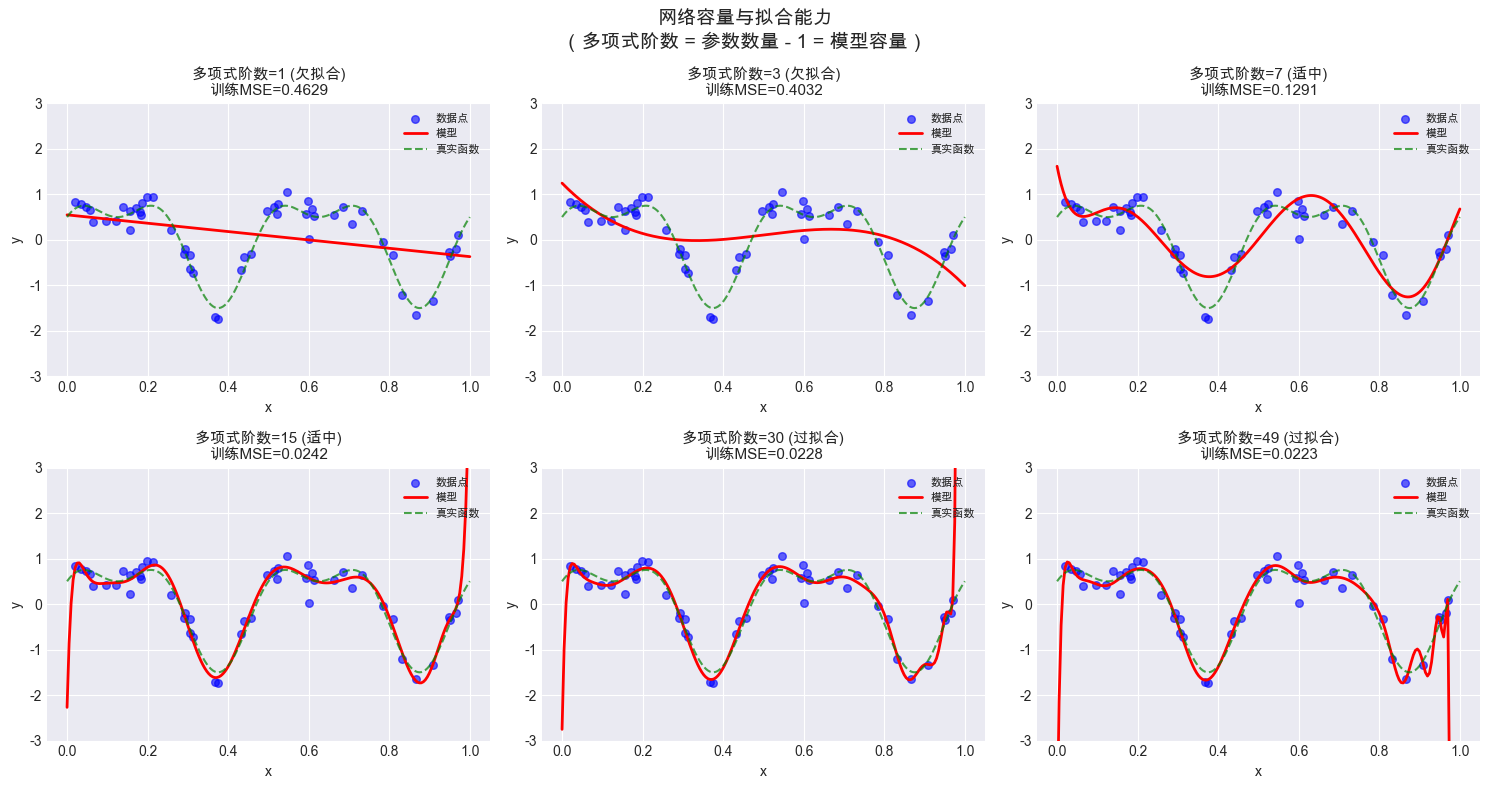


观察：
- 容量太小（低阶多项式）：欠拟合，无法捕捉数据的复杂模式
- 容量适中：较好地拟合数据，同时保持平滑
- 容量太大（高阶多项式）：过拟合，拟合了噪声，泛化差


In [10]:
def visualize_capacity():
    """
    可视化网络容量对拟合能力的影响
    """
    # 生成复杂的目标数据
    np.random.seed(42)
    n_points = 50
    x = np.sort(np.random.uniform(0, 1, n_points))
    y_true = np.sin(4 * np.pi * x) + 0.5 * np.cos(8 * np.pi * x)
    noise = np.random.normal(0, 0.2, n_points)
    y = y_true + noise
    
    # 不同容量的模型
    def fit_polynomial(x, y, degree):
        """拟合多项式模型"""
        coeffs = np.polyfit(x, y, degree)
        return np.poly1d(coeffs)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    degrees = [1, 3, 7, 15, 30, 49]  # 不同复杂度
    x_plot = np.linspace(0, 1, 200)
    
    for ax, degree in zip(axes.flat, degrees):
        model = fit_polynomial(x, y, degree)
        y_pred = model(x_plot)
        
        # 计算训练误差
        train_error = np.mean((model(x) - y) ** 2)
        
        ax.scatter(x, y, c='blue', s=30, alpha=0.6, label='数据点')
        ax.plot(x_plot, y_pred, 'r-', linewidth=2, label='模型')
        ax.plot(x_plot, np.sin(4*np.pi*x_plot) + 0.5*np.cos(8*np.pi*x_plot), 
                'g--', linewidth=1.5, alpha=0.7, label='真实函数')
        
        status = '欠拟合' if degree < 5 else ('过拟合' if degree > 20 else '适中')
        ax.set_title(f'多项式阶数={degree} ({status})\n训练MSE={train_error:.4f}', fontsize=11)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_ylim(-3, 3)
        ax.legend(loc='upper right', fontsize=8)
    
    plt.suptitle('网络容量与拟合能力\n（多项式阶数 = 参数数量 - 1 = 模型容量）', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\n观察：")
    print("- 容量太小（低阶多项式）：欠拟合，无法捕捉数据的复杂模式")
    print("- 容量适中：较好地拟合数据，同时保持平滑")
    print("- 容量太大（高阶多项式）：过拟合，拟合了噪声，泛化差")

visualize_capacity()

---

## 5. 总结与激活函数选择指南

### 5.1 激活函数选择建议

| 任务类型 | 推荐激活函数 |
|---------|------------|
| 图像分类（CNN） | ReLU, Swish, Mish |
| 自然语言处理（Transformer） | GELU |
| 通用深度学习 | ReLU（默认）, Swish（追求性能） |
| 避免Dead ReLU | Leaky ReLU, ELU, Swish |
| 需要平滑激活 | Swish, GELU, Mish |

### 5.2 关键要点

1. **新型激活函数**（Swish, GELU, Mish）通常比ReLU表现更好
2. **万能近似定理**保证了神经网络的强大表达能力
3. **深度通常比宽度更重要**，但需要配合残差连接等技术
4. **网络容量要匹配问题复杂度**，过大或过小都不好

---

## 6. 练习题

### 练习1：实现SiLU

SiLU（Sigmoid Linear Unit）是Swish的另一个名字（β=1）。实现SiLU及其导数。

### 练习2：比较激活函数在MNIST上的效果

训练一个简单的MLP，比较ReLU、Swish、GELU在MNIST数据集上的分类准确率。

### 练习3（挑战）：可视化激活函数对梯度流的影响

创建一个深层网络，可视化不同激活函数下梯度的传播情况。

In [ ]:
# 练习答案区域

def exercise_1_silu():
    """
    练习1: 实现SiLU
    """
    # SiLU就是Swish(β=1)
    def silu(x):
        return x * sigmoid(x)
    
    def silu_derivative(x):
        sig = sigmoid(x)
        return sig + x * sig * (1 - sig)
    
    # 验证
    x = np.linspace(-5, 5, 100)
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, silu(x), label='SiLU')
    plt.plot(x, swish(x, 1.0), '--', label='Swish(β=1)')
    plt.legend()
    plt.title('SiLU vs Swish(β=1)\n（应该完全重叠）')
    
    plt.subplot(1, 2, 2)
    plt.plot(x, silu_derivative(x), label='SiLU导数')
    plt.legend()
    plt.title('SiLU导数')
    
    plt.tight_layout()
    plt.show()

exercise_1_silu()

练习2: 比较ReLU、Swish、GELU在MNIST上的效果

[1/4] 加载MNIST数据集...
   训练集: 8000 样本
   测试集: 2000 样本
   特征维度: 784
   类别数: 10

[2/4] 训练模型...

   训练 RELU 模型:
      Epoch  10: Loss=0.0116, Train Acc=99.99%, Test Acc=94.20%
      Epoch  20: Loss=0.0028, Train Acc=100.00%, Test Acc=94.50%
      Epoch  30: Loss=0.0015, Train Acc=100.00%, Test Acc=94.40%
   RELU 最终测试准确率: 94.40%

   训练 SWISH 模型:
      Epoch  10: Loss=0.0127, Train Acc=99.98%, Test Acc=94.65%
      Epoch  20: Loss=0.0027, Train Acc=100.00%, Test Acc=94.35%
      Epoch  30: Loss=0.0014, Train Acc=100.00%, Test Acc=94.55%
   SWISH 最终测试准确率: 94.55%

   训练 GELU 模型:
      Epoch  10: Loss=0.0096, Train Acc=99.99%, Test Acc=93.95%
      Epoch  20: Loss=0.0025, Train Acc=100.00%, Test Acc=93.95%
      Epoch  30: Loss=0.0013, Train Acc=100.00%, Test Acc=94.10%
   GELU 最终测试准确率: 94.10%

[3/4] 生成可视化图表...


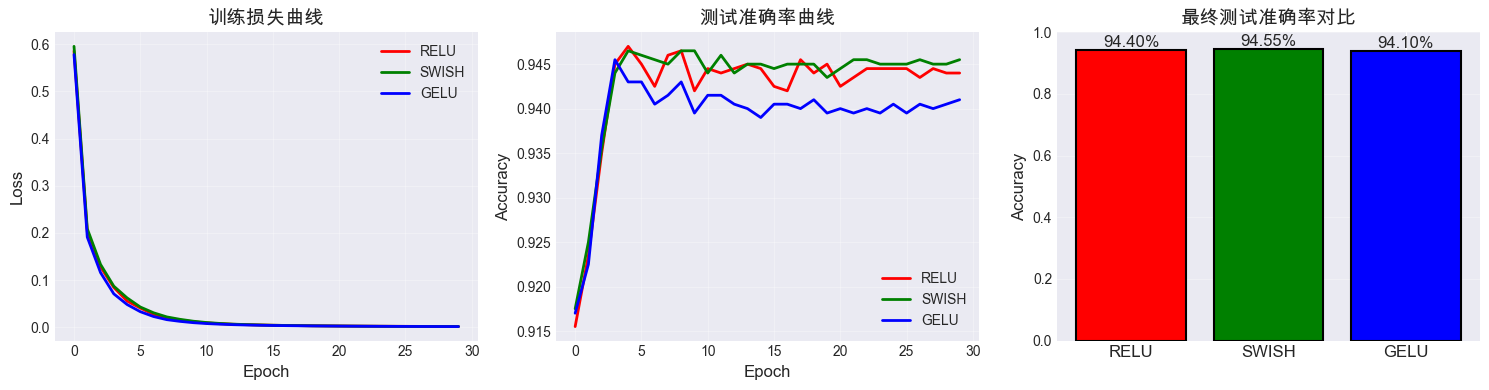


[4/4] 结果总结

最终测试准确率:
   RELU    : 94.40%
   SWISH   : 94.55%
   GELU    : 94.10%

最佳激活函数: SWISH (94.55%)

分析:
- 三种激活函数在MNIST上都能达到较好的效果
- Swish和GELU通常比ReLU收敛更平滑
- 在更复杂的任务中，Swish/GELU可能优势更明显
- GELU是Transformer模型的标准选择


In [11]:
def exercise_2_mnist_comparison():
    """
    练习2: 比较ReLU、Swish、GELU在MNIST数据集上的效果
    
    实现一个简单的MLP，训练并比较三种激活函数的分类准确率
    """
    from sklearn.datasets import fetch_openml
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    print("=" * 60)
    print("练习2: 比较ReLU、Swish、GELU在MNIST上的效果")
    print("=" * 60)
    
    # ==================== 1. 加载MNIST数据 ====================
    print("\n[1/4] 加载MNIST数据集...")
    
    # 使用sklearn加载MNIST（会自动下载）
    # 为了加速演示，我们只使用部分数据
    try:
        mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')
        X, y = mnist.data, mnist.target.astype(int)
    except:
        # 如果无法下载，使用模拟数据
        print("无法下载MNIST，使用模拟数据进行演示...")
        np.random.seed(42)
        X = np.random.randn(10000, 784)
        y = np.random.randint(0, 10, 10000)
    
    # 只使用前10000个样本加速训练
    X = X[:10000]
    y = y[:10000]
    
    # 数据预处理
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    print(f"   训练集: {X_train.shape[0]} 样本")
    print(f"   测试集: {X_test.shape[0]} 样本")
    print(f"   特征维度: {X_train.shape[1]}")
    print(f"   类别数: {len(np.unique(y))}")
    
    # ==================== 2. 定义MLP类 ====================
    class SimpleMLP:
        """
        简单的多层感知机，支持不同激活函数
        
        网络结构: 784 -> 128 -> 64 -> 10
        """
        
        def __init__(self, activation='relu', learning_rate=0.01):
            """
            初始化网络
            
            参数:
                activation: str, 激活函数类型 ('relu', 'swish', 'gelu')
                learning_rate: float, 学习率
            """
            self.activation_name = activation
            self.lr = learning_rate
            
            # 选择激活函数及其导数
            if activation == 'relu':
                self.activation = lambda x: np.maximum(0, x)
                self.activation_derivative = lambda x: (x > 0).astype(float)
            elif activation == 'swish':
                self.activation = lambda x: x * sigmoid(x)
                self.activation_derivative = lambda x: (
                    sigmoid(x) + x * sigmoid(x) * (1 - sigmoid(x))
                )
            elif activation == 'gelu':
                self.activation = gelu_exact
                self.activation_derivative = gelu_derivative
            else:
                raise ValueError(f"不支持的激活函数: {activation}")
            
            # He初始化权重
            np.random.seed(42)  # 保证可重复性
            self.W1 = np.random.randn(784, 128) * np.sqrt(2.0 / 784)
            self.b1 = np.zeros(128)
            self.W2 = np.random.randn(128, 64) * np.sqrt(2.0 / 128)
            self.b2 = np.zeros(64)
            self.W3 = np.random.randn(64, 10) * np.sqrt(2.0 / 64)
            self.b3 = np.zeros(10)
            
            # 记录训练历史
            self.train_losses = []
            self.train_accs = []
            self.test_accs = []
        
        def softmax(self, x):
            """Softmax激活函数（用于输出层）"""
            exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=1, keepdims=True)
        
        def forward(self, X):
            """前向传播"""
            # 第一层
            self.z1 = X @ self.W1 + self.b1
            self.a1 = self.activation(self.z1)
            
            # 第二层
            self.z2 = self.a1 @ self.W2 + self.b2
            self.a2 = self.activation(self.z2)
            
            # 输出层（Softmax）
            self.z3 = self.a2 @ self.W3 + self.b3
            self.a3 = self.softmax(self.z3)
            
            return self.a3
        
        def backward(self, X, y_onehot):
            """反向传播"""
            m = X.shape[0]
            
            # 输出层梯度（交叉熵 + Softmax的简化形式）
            dz3 = self.a3 - y_onehot
            dW3 = self.a2.T @ dz3 / m
            db3 = np.mean(dz3, axis=0)
            
            # 第二层梯度
            da2 = dz3 @ self.W3.T
            dz2 = da2 * self.activation_derivative(self.z2)
            dW2 = self.a1.T @ dz2 / m
            db2 = np.mean(dz2, axis=0)
            
            # 第一层梯度
            da1 = dz2 @ self.W2.T
            dz1 = da1 * self.activation_derivative(self.z1)
            dW1 = X.T @ dz1 / m
            db1 = np.mean(dz1, axis=0)
            
            # 更新权重
            self.W3 -= self.lr * dW3
            self.b3 -= self.lr * db3
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
        
        def compute_loss(self, y_pred, y_onehot):
            """计算交叉熵损失"""
            epsilon = 1e-10
            return -np.mean(np.sum(y_onehot * np.log(y_pred + epsilon), axis=1))
        
        def train(self, X_train, y_train, X_test, y_test, epochs=30, batch_size=64):
            """训练模型"""
            # One-hot编码
            n_classes = 10
            y_train_onehot = np.eye(n_classes)[y_train]
            
            n_samples = X_train.shape[0]
            n_batches = n_samples // batch_size
            
            for epoch in range(epochs):
                # 打乱数据
                indices = np.random.permutation(n_samples)
                X_shuffled = X_train[indices]
                y_shuffled = y_train_onehot[indices]
                
                epoch_loss = 0
                
                # Mini-batch训练
                for i in range(n_batches):
                    start = i * batch_size
                    end = start + batch_size
                    X_batch = X_shuffled[start:end]
                    y_batch = y_shuffled[start:end]
                    
                    # 前向传播
                    y_pred = self.forward(X_batch)
                    epoch_loss += self.compute_loss(y_pred, y_batch)
                    
                    # 反向传播
                    self.backward(X_batch, y_batch)
                
                # 记录历史
                avg_loss = epoch_loss / n_batches
                train_acc = self.evaluate(X_train, y_train)
                test_acc = self.evaluate(X_test, y_test)
                
                self.train_losses.append(avg_loss)
                self.train_accs.append(train_acc)
                self.test_accs.append(test_acc)
                
                if (epoch + 1) % 10 == 0:
                    print(f"      Epoch {epoch+1:3d}: Loss={avg_loss:.4f}, "
                          f"Train Acc={train_acc:.2%}, Test Acc={test_acc:.2%}")
        
        def evaluate(self, X, y):
            """评估准确率"""
            y_pred = self.forward(X)
            predictions = np.argmax(y_pred, axis=1)
            return np.mean(predictions == y)
    
    # ==================== 3. 训练三种激活函数 ====================
    print("\n[2/4] 训练模型...")
    
    activations = ['relu', 'swish', 'gelu']
    models = {}
    results = {}
    
    for act in activations:
        print(f"\n   训练 {act.upper()} 模型:")
        model = SimpleMLP(activation=act, learning_rate=0.1)
        model.train(X_train, y_train, X_test, y_test, epochs=30, batch_size=64)
        
        final_acc = model.evaluate(X_test, y_test)
        models[act] = model
        results[act] = final_acc
        print(f"   {act.upper()} 最终测试准确率: {final_acc:.2%}")
    
    # ==================== 4. 可视化结果 ====================
    print("\n[3/4] 生成可视化图表...")
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    colors = {'relu': 'red', 'swish': 'green', 'gelu': 'blue'}
    
    # 左图：训练损失
    ax1 = axes[0]
    for act in activations:
        ax1.plot(models[act].train_losses, label=act.upper(), 
                 color=colors[act], linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('训练损失曲线', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 中图：测试准确率
    ax2 = axes[1]
    for act in activations:
        ax2.plot(models[act].test_accs, label=act.upper(), 
                 color=colors[act], linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title('测试准确率曲线', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 右图：最终准确率对比（柱状图）
    ax3 = axes[2]
    x_pos = np.arange(len(activations))
    bars = ax3.bar(x_pos, [results[act] for act in activations],
                   color=[colors[act] for act in activations],
                   edgecolor='black', linewidth=1.5)
    
    # 在柱状图上显示数值
    for bar, act in zip(bars, activations):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                 f'{results[act]:.2%}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax3.set_xticks(x_pos)
    ax3.set_xticklabels([act.upper() for act in activations], fontsize=12)
    ax3.set_ylabel('Accuracy', fontsize=12)
    ax3.set_title('最终测试准确率对比', fontsize=14)
    ax3.set_ylim(0, 1.0)
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # ==================== 5. 结果总结 ====================
    print("\n[4/4] 结果总结")
    print("=" * 60)
    print("\n最终测试准确率:")
    for act in activations:
        print(f"   {act.upper():8s}: {results[act]:.2%}")
    
    best_act = max(results, key=results.get)
    print(f"\n最佳激活函数: {best_act.upper()} ({results[best_act]:.2%})")
    
    print("\n分析:")
    print("- 三种激活函数在MNIST上都能达到较好的效果")
    print("- Swish和GELU通常比ReLU收敛更平滑")
    print("- 在更复杂的任务中，Swish/GELU可能优势更明显")
    print("- GELU是Transformer模型的标准选择")
    
    return models, results

# 运行练习2
models, results = exercise_2_mnist_comparison()

---

## 参考资料

1. **Swish**: Ramachandran et al., "Searching for Activation Functions" (2017)
2. **GELU**: Hendrycks & Gimpel, "Gaussian Error Linear Units" (2016)
3. **Mish**: Misra, "Mish: A Self Regularized Non-Monotonic Activation Function" (2019)
4. **万能近似定理**: Cybenko, "Approximation by Superpositions of a Sigmoidal Function" (1989)
5. **深度vs宽度**: Lu et al., "The Expressive Power of Neural Networks: A View from the Width" (2017)

---

**下一章预告**: 04b_autograd_engine.ipynb - 自动微分引擎与梯度流可视化